당뇨병 예측 데이터를 활용한 모델 비교 및 주요 위험요인 선별

# 데이터 전처리

## import
> pandas, numpy, matplotlib

> get df

In [82]:
# pandas, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [83]:
# get df
df = pd.read_csv("/content/drive/MyDrive/데분데분/diabetes_prediction_dataset.csv")

## 01. 데이터 수정
> 결측치 처리

> 중복된 행 제거

> 나이 변수 형변환
* float -> int

In [84]:
# 결측치 처리
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [85]:
# 중복된 행 제거
df.duplicated().sum()
df.shape

(100000, 9)

In [86]:
# 나이 변수 형변환
df['age'] = df['age'].astype(int)

## gender
> ~Others~

> dummy

In [87]:
# remove Others
df = df[df['gender'] != 'Other']

In [88]:
# dummy
gender_dummies = pd.get_dummies(df['gender'])
df = pd.concat([df, gender_dummies], axis = 1)
df=df.drop(['gender'],axis = 1)

## smoking_history
> smoking_history 열 전체 제거

In [89]:
# smoking_history 열 전체 제거
df.drop(["smoking_history"], axis = 1, inplace = True)

## diabetes
> 맨 오른쪽 열으로 이동

In [90]:
# 맨 오른쪽 열으로 이동
cols = df.columns.tolist()
cols.remove('diabetes')
df = df[cols+['diabetes']]

## train/test split
> set X, y

> train_test_split

In [91]:
# set X, y
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [92]:
# train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Undersampling / Oversampling | w/ logistic

## import
> recall_score, LogisticRegression

In [93]:
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression

In [94]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## Undersampling
> Undersampling

> Logistic Regression

In [95]:
# Undersampling
from imblearn.under_sampling import RandomUnderSampler

max_dia = df[df['diabetes'] == 1]
min_dia = df[df['diabetes'] == 0]
undersample = RandomUnderSampler(random_state = 42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
y_train_under.value_counts()

0    6792
1    6792
Name: diabetes, dtype: int64

In [96]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_under,y_train_under)
'''
lasso_lr = LogisticRegression(penalty='l2')
lasso_lr.fit(X_train_under, y_train_under)
score = lasso_lr.score(X_train_under, y_train_under)
print(score)
릿지라쏘 규제
'''

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


"\nlasso_lr = LogisticRegression(penalty='l2')\nlasso_lr.fit(X_train_under, y_train_under)\nscore = lasso_lr.score(X_train_under, y_train_under)\nprint(score)\n릿지라쏘 규제\n"

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
from sklearn.metrics import roc_auc_score
prediction_train = lr.predict(X_train_under)
prediction_test = lr.predict(X_test)
print('roc auc value train : {}'.format(roc_auc_score(y_train_under,prediction_train)))
print('roc auc value test: {}'.format(roc_auc_score(y_test,prediction_test)))

roc auc value train : 0.8861896348645466
roc auc value test: 0.8885362779971785


랜덤 포레스트

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [100]:
# Undersampled X, y를 활용한 랜덤포레스트 구성
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state = 42, n_estimators = 200, max_depth = 11)
rf_clf.fit(X_train_under, y_train_under)

y_train_pred = rf_clf.predict(X_train_under)
y_test_pred = rf_clf.predict(X_test)

In [101]:
# Grid Search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : [10,50,100,200,300,500],
          'max_depth' : [4,5,6,7,8,9,10,11,12],
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf_under = RandomForestClassifier(random_state = 0)            # n_jobs = -1
grid_cv = GridSearchCV(rf_clf_under, param_grid = params, cv = 3)            # n_jobs = -1
grid_cv.fit(X_train_under, y_train_under)

print('언더모델 최적 하이퍼파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

언더모델 최적 하이퍼파라미터:  {'max_depth': 11, 'n_estimators': 200}
최고 예측 정확도: 0.9101


In [102]:
from sklearn.metrics import roc_auc_score
# auc score
print('roc_auc_score_train:', roc_auc_score(y_train_under, y_train_pred))
print('roc_auc_score_test:', roc_auc_score(y_test, y_test_pred))

roc_auc_score_train: 0.9218934040047114
roc_auc_score_test: 0.9092858154458158


SVM

In [103]:
# SVM : 'linear(선형)'
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

svm = SVC(kernel = 'linear')
svm.fit(X_train_under, y_train_under)

y_train_pred = svm.predict(X_train_under)
y_test_pred = svm.predict(X_test)

# auc
print('roc auc value train : {}'.format(roc_auc_score(y_train_under,y_train_pred)))
print('roc auc value test: {}'.format(roc_auc_score(y_test,y_test_pred)))

roc auc value train : 0.8869994110718492
roc auc value test: 0.8889451280718897


In [104]:
# SVM : 'poly(다중)'

import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

svm = SVC(kernel = 'poly')
svm.fit(X_train_under, y_train_under)

y_train_pred = svm.predict(X_train_under)
y_test_pred = svm.predict(X_test)

# auc
print('roc auc value train : {}'.format(roc_auc_score(y_train_under,y_train_pred)))
print('roc auc value test: {}'.format(roc_auc_score(y_test,y_test_pred)))

roc auc value train : 0.8593197879858656
roc auc value test: 0.8711764362781637


In [105]:
# SVM : 'rbf(가우시안)'
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

svm = SVC(kernel = 'rbf')
svm.fit(X_train_under, y_train_under)

y_train_pred = svm.predict(X_train_under)
y_test_pred = svm.predict(X_test)

# auc
print('roc auc value train : {}'.format(roc_auc_score(y_train_under,y_train_pred)))
print('roc auc value test: {}'.format(roc_auc_score(y_test,y_test_pred)))

roc auc value train : 0.8589517078916372
roc auc value test: 0.864997218737463


Feature Importance

In [106]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_under, y_train_under)

RandomForestClassifier()

In [107]:
feature_importance_under = pd.DataFrame(rf_clf.feature_importances_.reshape((1, -1)), columns=X_train_under.columns, index=['feature_importance_under'])
feature_importance_under

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,Female,Male
feature_importance_under,0.186551,0.027304,0.016298,0.142966,0.33989,0.281759,0.002382,0.002851


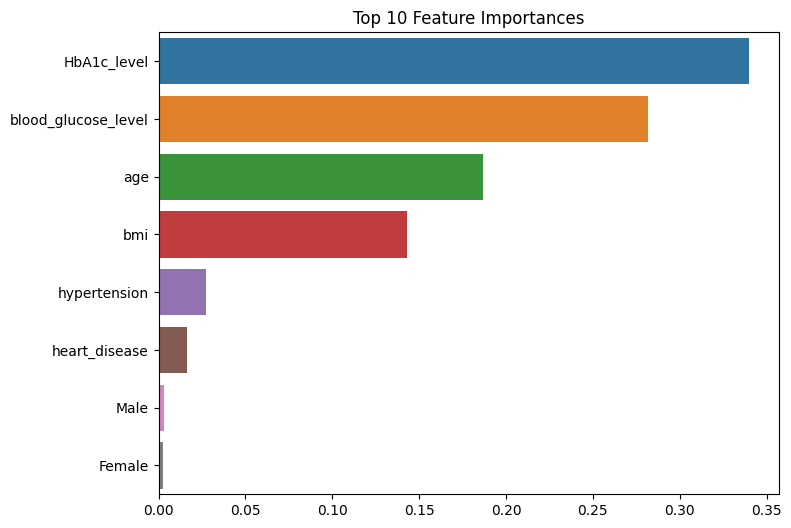

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train_under.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances')
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show()